In [1]:
from experiments.experiments import train, evaluate
from experiments.utils import *
from agent.agents import *
from agent.switching_agents import *
from environments.env import * 
from definitions import ROOT_DIR

from torch.optim import *
import numpy as np
import random 
import torch
import pickle
from copy import deepcopy


np.random.seed(12345678)
random.seed(12345678)
torch.manual_seed(12345678)


## Train baselines and 2-stage algorithm

### Configure Environment

In [3]:
env_generator = Environment()
width = 3
height = 20
depth = height//3
init_traffic_level = 'light'
env_params = {'width' : width, 'height':height, 'init_traffic_level': init_traffic_level, 'depth': depth}
env_generator_fn = lambda:env_generator.generate_grid_world(**env_params)
n_actions = 3

### Configure Agents

In [4]:
# Human 
estimation_noise = 2.0
switching_noise = 0.0
c_H = 0.0

# Machine

# state size with string features
n_state_features_strings = env_generator.n_state_strings(depth, width)

# define state size in 1-hot encoding
n_state_features_1hot =  env_generator.n_state_one_hot(depth, width)

n_state_features = (n_state_features_strings, n_state_features_1hot)

c_M = 0.2
lr = 1e-4
optimizer_fn = lambda params: RMSprop(params, lr)

# Switching Agent
epsilon = 0.1

### Initialize Agents

In [4]:
human  = NoisyDriverAgent(env_generator, noise_sd=estimation_noise, noise_sw=switching_noise, c_H=c_H)

machine = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=c_M, entropy_weight = 0.)

machine_only = FixedSwitchingMachine(n_state_features, optimizer_fn, c_M=c_M)

human_only = FixedSwitchingHuman()

switch_fixed_policies = SwitchingAgent(n_state_features, optimizer_fn, c_M=c_M, c_H=c_H, eps=epsilon)

# same initialisation
switch_full = SwitchingAgent(n_state_features, optimizer_fn, c_M=c_M, c_H=c_H, eps=epsilon)
# must be deepcopy of machine before training
switch_machine = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=c_M)


### Train Steps

In [8]:
n_traj = 0
n_episodes = 2500

### Gather human traces

In [6]:
%%time
# gather human trajectories
trajectories = gather_human_trajectories(human, env_generator, n_traj,**env_params)
# save for later
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}', 'wb') as file:
    pickle.dump(trajectories, file, pickle.HIGHEST_PROTOCOL)
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_agent', 'wb') as file:
    pickle.dump(human, file, pickle.HIGHEST_PROTOCOL)
    

Wall time: 8 ms


In [9]:

with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}', 'rb') as file:
    trajectories = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_{n_traj}_agent', 'rb') as file:
    human = pickle.load(file)

### Evaluation Parametes

In [5]:
n_eval_set_size = 1000
eval_freq = 500
save_freq = 10000
eval_set = [ env_generator_fn() for i in range(n_eval_set_size)]

### Training

In [10]:
machine.trainable = True

In [12]:

machine_only_algo = {'pre_trained_machine': (machine_only, [human, machine])}
machine_only_algo, machine_only_costs = train(machine_only_algo, [], env_generator_fn, n_episodes, eval_set, eval_freq, save_freq)

2021-05-24 11:35:23.834752, On-policy, Episode 1000, pre_trained_machine  evaluation cost: 19.202
2021-05-24 11:40:07.895999, On-policy, Episode 2000, pre_trained_machine  evaluation cost: 18.334
2021-05-24 11:44:49.753120, On-policy, Episode 3000, pre_trained_machine  evaluation cost: 17.506
2021-05-24 11:49:31.981263, On-policy, Episode 4000, pre_trained_machine  evaluation cost: 16.498
2021-05-24 11:54:17.236578, On-policy, Episode 5000, pre_trained_machine  evaluation cost: 16.304


In [6]:
human_cost = evaluate(human_only, [human], eval_set)
print(human_cost)

10.402


In [9]:
machine.trainable = False
algos = {'fixed_policies': (switch_fixed_policies,[human, machine])}
algos, algos_costs = train(algos, [], env_generator_fn, n_episodes, eval_set, eval_freq, save_freq)

2021-05-24 13:52:32.823423, On-policy, Episode 500, fixed_policies  evaluation cost: 10.576
2021-05-24 13:55:06.403207, On-policy, Episode 1000, fixed_policies  evaluation cost: 10.354
2021-05-24 13:57:40.007993, On-policy, Episode 1500, fixed_policies  evaluation cost: 10.682
2021-05-24 14:00:21.012202, On-policy, Episode 2000, fixed_policies  evaluation cost: 10.578
2021-05-24 14:04:14.658566, On-policy, Episode 2500, fixed_policies  evaluation cost: 10.518


In [8]:
%%time

machine.trainable = False
algos = {'fixed_policies': (switch_fixed_policies,[human, machine]), 'switching':( switch_full,[human, switch_machine]) }

algos, algos_costs = train(algos, [], env_generator_fn, n_episodes, eval_set, eval_freq, save_freq)


2021-05-24 11:14:19.513437, On-policy, Episode 200, fixed_policies  evaluation cost: 12.0094
2021-05-24 11:15:06.223108, On-policy, Episode 200, switching  evaluation cost: 12.022
2021-05-24 11:17:11.290262, On-policy, Episode 400, fixed_policies  evaluation cost: 11.919599999999999
2021-05-24 11:17:59.017992, On-policy, Episode 400, switching  evaluation cost: 11.916599999999999
2021-05-24 11:20:06.435279, On-policy, Episode 600, fixed_policies  evaluation cost: 12.192599999999999
2021-05-24 11:20:53.513972, On-policy, Episode 600, switching  evaluation cost: 11.605399999999998
2021-05-24 11:23:01.026265, On-policy, Episode 800, fixed_policies  evaluation cost: 12.0216
2021-05-24 11:23:49.154018, On-policy, Episode 800, switching  evaluation cost: 11.878
2021-05-24 11:25:59.211457, On-policy, Episode 1000, fixed_policies  evaluation cost: 11.9902
2021-05-24 11:26:48.158257, On-policy, Episode 1000, switching  evaluation cost: 11.787799999999999
Wall time: 14min 40s


## Evaluate Performance

In [5]:
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_trajectories_50000_agent', 'rb') as file:
    human = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/trajectories/human_{estimation_noise}_{switching_noise}_{init_traffic_level}_cost', 'rb') as file :
    human_cost = pickle.load (file)
with open(f'{ROOT_DIR}/outputs/eval_set', 'rb') as file:
    eval_set = pickle.load(file)

algos = {'human_only': [human_cost]*30}
for agent in ['machine_online_entorpy_weight_decay','pre_trained_machine_online', 'pre_trained_machine','fixed_policies','switching', 'machine_rnd_human', 'switching_batched','switching_eval_exp']:
    # with open(f'{ROOT_DIR}/outputs/agents/{agent}/costs_off', 'rb') as file:
    #     off = pickle.load(file)
    #     print(off[-1])
    #     algos[agent] = off
    with open(f'{ROOT_DIR}/outputs/agents/{agent}/costs_on', 'rb') as file:
        on = pickle.load(file)
        print(len(on))
        algos[agent]= on



30
30
30
30
30
30
30
30


In [30]:
algos_75K = {'human_only':[human_cost]*75}
for agent in ['machine_only_75K', 'fixed_policies_75K', 'switching_75K']:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}/costs_on', 'rb') as file:
        on = pickle.load(file)
        algos_75K[agent]= on

algos_100K = {'human_only':[human_cost]*100, 'optimal':[8.372]*100,'machine_online_100K':[], 'machine_only_50K_on_after_off':[] }
with open(f'{ROOT_DIR}/outputs/agents/ent_batched/machine_only_75K/costs_off', 'rb') as file:
    off = pickle.load(file)
    algos_100K['machine_only_50K_on_after_off'].extend(off)

for agent in ['machine_online_100K', 'machine_only_50K_on_after_off']:
    with open(f'{ROOT_DIR}/outputs/agents/ent_batched/{agent}/costs_on', 'rb') as file:
        on = pickle.load(file)
        algos_100K[agent].extend(on)


In [162]:
with open(f'{ROOT_DIR}/outputs/agents/pre_trained_machine_50K/actor_agent_off', 'rb') as file:
    actor_off = pickle.load(file)
with open(f'{ROOT_DIR}/outputs/agents/pre_trained_machine_50K/switching_agent_off', 'rb') as file:
    switching_off = pickle.load(file)
cost = evaluate(switching_off, [human, actor_off], eval_set)
algos['pre_trained_machine'][49], cost

(17.094, 16.756)

In [18]:
# human_cost = evaluate(human_only, [human], eval_set)
# full_offline = algos_costs['switching'][n_traj - 1 ]
# algos_costs ={**algos_costs, **machine_only_costs}
# switch_costs = { alg: algos_costs[alg][(n_traj - 1):] for alg in algos_costs}
costs = {'human_only': [human_cost]*n_episodes, **switch_costs}


<AxesSubplot:>

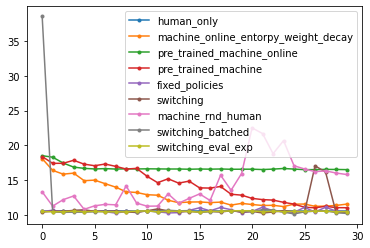

In [23]:
import pandas as pd

df = pd.DataFrame(algos)
df.plot(style='.-')


<AxesSubplot:>

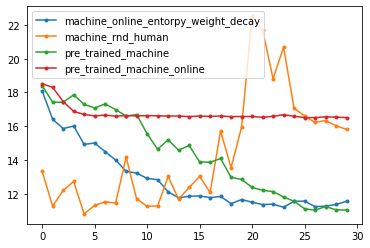

In [7]:
df[['machine_online_entorpy_weight_decay','machine_rnd_human','pre_trained_machine','pre_trained_machine_online']].plot(style='.-')


<AxesSubplot:>

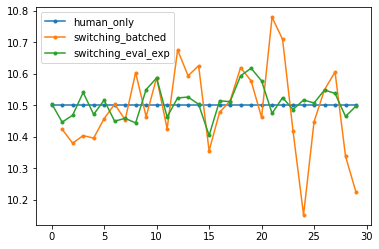

In [25]:
df[['human_only','switching','switching_eval_exp']][df<11.3].plot(style='.-')


<AxesSubplot:>

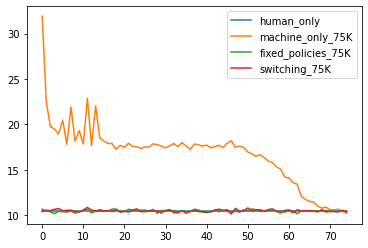

In [23]:
import pandas as pd
df_75 = pd.DataFrame(algos_75K)
df_75.plot()

<AxesSubplot:>

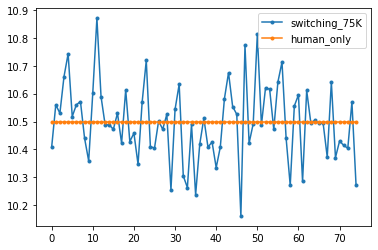

In [18]:
df_75[['switching_75K', 'human_only']].plot(style='.-')


<AxesSubplot:>

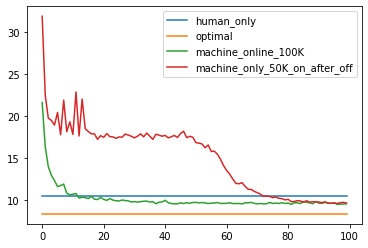

In [32]:
df_100 = pd.DataFrame(algos_100K)
df_100.plot(style='-')

In [35]:
df_100['machine_online_100K'][20: 50]

20    10.110
21     9.980
22    10.206
23    10.018
24     9.942
25     9.912
26    10.030
27     9.964
28     9.932
29     9.786
30     9.844
31     9.776
32     9.836
33     9.880
34     9.900
35     9.790
36     9.828
37     9.582
38     9.764
39     9.788
40     9.990
41     9.706
42     9.608
43     9.570
44     9.572
45     9.696
46     9.606
47     9.700
48     9.644
49     9.728
Name: machine_online_100K, dtype: float64

<AxesSubplot:>

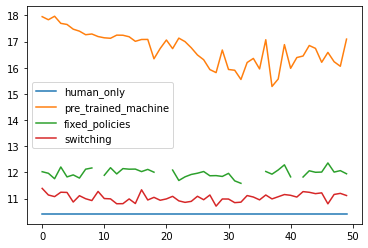

In [20]:
import pandas as pd

df = pd.DataFrame(algos)
df.iloc[:50][(df < 20) ].plot()

<AxesSubplot:>

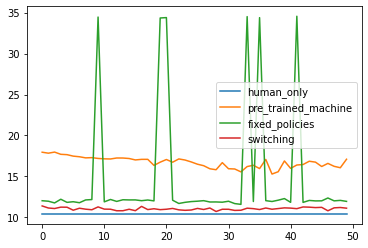

In [147]:
df.iloc[:50].plot()

<AxesSubplot:>

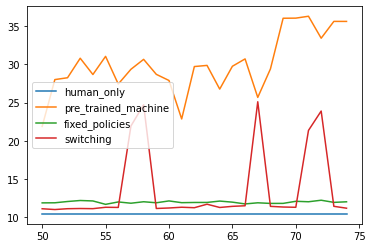

In [145]:
df[50:].plot()

# Playground

In [4]:
 on_off = 'off'
 name = 'pre_trained_machine'
 with open(f'{ROOT_DIR}/outputs/agents/{name}/costs_'+on_off, 'rb') as file:
    costs = pickle.load(file)

costs

[35.658,
 23.038,
 22.272,
 31.012000000000004,
 19.382,
 17.158,
 36.63,
 18.792,
 29.298000000000005,
 37.56]

In [3]:
%%time
fully_automated, [human, machine] , fully_automated_costs = run_pre_train_machine(fully_automated, [human, machine], trajectories, env_generator_fn, n_episodes)

2021-05-17 20:45:13.320152, Episode 1000, Fully automated on-policy algorithm cumulative cost: 35535.8
2021-05-17 20:47:13.406020, Episode 2000, Fully automated on-policy algorithm cumulative cost: 72123.8
2021-05-17 20:49:16.207044, Episode 3000, Fully automated on-policy algorithm cumulative cost: 109591.80000000002
2021-05-17 20:51:19.102073, Episode 4000, Fully automated on-policy algorithm cumulative cost: 147059.8
Wall time: 29min 1s


In [23]:
from plot.plot_path import PlotPath
from experiments.utils import *
gird_world = env_generator_fn()
plt_path = PlotPath(gird_world, n_try=1)
plt_path1 = PlotPath(gird_world, n_try=1)



cost = learn_evaluate(fully_automated, [human, machine] ,gird_world , 
is_learn=False, plt_path = plt_path, machine_only=True)

cost1 = learn_evaluate(f_a, [human,  switch_machine] ,gird_world ,
is_learn=False, plt_path = plt_path1)

plt_path.plot('../machine_only_light.png')
plt_path1.plot('../machine_dummy_only_light.png')

print(cost, cost1)

39.8 57.8


In [7]:
from plot.plot_path import PlotPath
from experiments.utils import *
grid = eval_set[4]
plt_path = PlotPath(grid, n_try=1)
optimal = OptimalAgent(grid, 0.2)
cost  = optimal.eval(plt_path=plt_path)
plt_path.plot('../eval_set_light.png')

print(cost)

11.799999999999997


In [33]:
optimal_costs = [ OptimalAgent(grid, 0.2).eval() for grid in eval_set]
print(np.mean(optimal_costs))

8.371999999999998


In [10]:
optimal_costs = [ OptimalAgent(grid, 0.0).eval() for grid in eval_set]
print(np.mean(optimal_costs))

4.572


In [6]:
grid.type_costs

{'road': 0, 'grass': 2, 'stone': 4, 'car': 10}

In [22]:
res = []
for _ in range(10):
    is_better = 0
    for i in range(100):
        gird_world = env_generator_fn()
        cost = learn_evaluate(fully_automated, [human, machine] ,gird_world , 
        is_learn=False, plt_path = plt_path, machine_only=True)

        cost1 = learn_evaluate(f_a, [human,  switch_machine] ,gird_world , 
        is_learn=False, plt_path = plt_path1)

        is_better+= (cost1 >= cost)

    print(is_better/100)
    res.append(is_better/100)
    print(cost, cost1)
print(np.mean(res))

0.51
27.799999999999997 35.800000000000004
0.59
17.799999999999997 19.799999999999994
0.45
27.79999999999999 31.799999999999994
0.46
39.80000000000002 41.800000000000004
0.57
35.8 17.799999999999997
0.46
61.800000000000026 63.80000000000001
0.47
21.799999999999997 41.8
0.39
21.79999999999999 15.799999999999997
0.54
41.8 47.8
0.55
9.799999999999999 21.799999999999994
0.499


10000 off 15000 on
0.56
0.46
0.47
0.55
0.52
0.55
0.51
0.44
0.57
0.6
0.523

In [8]:
from copy import deepcopy
import torch
a = MachineDriverAgent(n_state_features, n_actions, optimizer_fn, c_M=0.2)
b = deepcopy(a)
torch.all(list(switch_machine.network.parameters())[0] == list(machine.network.parameters())[0])

tensor(False)

In [24]:
(list(machine.network.parameters())[3]).grad

tensor([4.2675e-14, 0.0000e+00, 2.3021e-14])

In [21]:
list(switch_machine.network.parameters())[3],list(machine.network.parameters())[3].grad

(Parameter containing:
 tensor([0., 0., 0.], requires_grad=True),
 tensor([-7.8448e-18,  0.0000e+00,  1.1218e-24]))